In [2]:
import os
import sys
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt

In [4]:
def load_activations(root):
    paths = sorted([f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))])
    actvs = []
    
    for path in paths:
        path = os.path.join(root, path)
        actvs += [np.load(path).squeeze(0)]
    
    return actvs

In [5]:
actvs = load_activations("/home/sadjad/projects/nnfc-temp/klt/activations")

In [8]:
len(actvs)

512

In [9]:
actvs[0].shape

(256, 52, 52)

In [61]:
block_size = (32, 13, 13)
train_data = []

for actv in actvs:
    for i in range(actv.shape[0] // block_size[0]):
        for j in range(actv.shape[1] // block_size[1]):
            for k in range(actv.shape[2] // block_size[2]):
                block = actv[i*block_size[0]:(i+1)*block_size[0],
                             j*block_size[1]:(j+1)*block_size[1],
                             k*block_size[2]:(k+1)*block_size[2]]
                train_data += [block.reshape(-1)]
                
tdata = np.array(train_data).T
M = np.mean(tdata, axis=1).reshape(-1, 1)
X = tdata - M

In [62]:
print(M.shape)
print(X.shape)

(5408, 1)
(5408, 65536)


In [63]:
eig_vals, eig_vecs = np.linalg.eig(np.cov(X))
sorted_idx = eig_vals.argsort()[::-1]
eig_vals = eig_vals[sorted_idx]
eig_vecs = eig_vecs[:, sorted_idx]

In [65]:
def do_klt_and_back(indata, eigs, means):
    klt = np.dot(eigs.T, indata - means.reshape(-1))
    outdata = np.dot(eig_vecs, klt) + means.reshape(-1)
    
    return klt, np.linalg.norm(outdata - indata, ord=1)

random_input = ((np.random.rand(*block_size) - 0.5) * 10.0).reshape(-1)
print(do_klt_and_back(random_input, eig_vecs, M)[1])

5.52267032661e-08


In [66]:
klt, err = do_klt_and_back(train_data[0] - M.reshape(-1), eig_vecs, M)
print(err)

9.73744573488e-05


In [45]:
np.argmin(klt)

14

In [68]:
np.save("/home/sadjad/projects/nnfc-temp/klt/transform", eig_vecs)
np.save("/home/sadjad/projects/nnfc-temp/klt/mean", M)

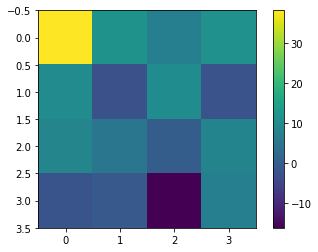

In [60]:
plt.imshow(klt.reshape(*block_size)[0])
plt.colorbar()

In [14]:
import scipy

In [15]:
scipy.fftpack.dct

<function scipy.fftpack.realtransforms.dct(x, type=2, n=None, axis=-1, norm=None, overwrite_x=False)>

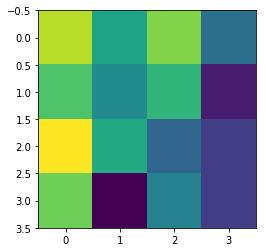

In [17]:
plt.imshow(scipy.fftpack.dct(train_data[0].reshape(4, 4)))